# Imports and Installations

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read in (corrected) data
boston = pd.read_csv("boston_corrected_corrected.csv")
boston.head()

,Unnamed: 0,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0,Nahant,0,2011,-70.927800,42.426000,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,1,Swampscott,1,2021,-70.919764,42.481455,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,2,Swampscott,1,2022,-70.897264,42.473777,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,3,Marblehead,2,2031,-70.884407,42.490840,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,4,Marblehead,2,2032,-70.874764,42.499371,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


# Data exploration

## Cleaning data

In [ ]:
print("Number of missing values:", boston.isnull().sum())
print("")
print("Are there any duplicated rows?", boston.duplicated().any())

Number of missing values: Unnamed: 0    0
TOWN          0
TOWNNO        0
TRACT         0
LON           0
LAT           0
MEDV          0
CMEDV         0
CRIM          0
ZN            0
INDUS         0
CHAS          0
NOX           0
RM            0
AGE           0
DIS           0
RAD           0
TAX           0
PTRATIO       0
B             0
LSTAT         0
dtype: int64

Are there any duplicated rows? False


## Exploring target distribution

In [ ]:
boston['CMEDV'].describe()

count    506.000000
mean      22.528854
std        9.182176
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: CMEDV, dtype: float64

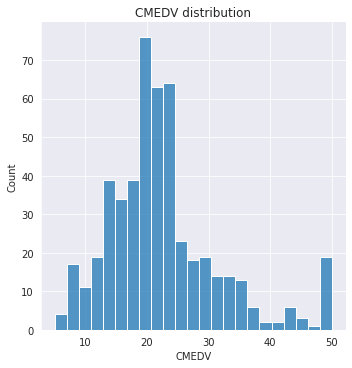

In [ ]:
sns.set_style('darkgrid')
CMEDV = sns.displot(boston['CMEDV'])
CMEDV.set(title = "CMEDV distribution")

Target variable skewed slightly to right of mean - we also see a build up at $50,000 (due to censored data)

## Exploring features

We shall drop all the location data and target variable data. 
We note that MEDV is dropped as CMEDV is simply a scaling of it.

In [ ]:
boston = boston.drop(columns=['Unnamed: 0'])
boston_trimmed = boston.drop(columns=['CMEDV', 'MEDV', 'TOWN', 'TOWNNO', 'TRACT', 'LON', 'LAT'])
boston_trimmed.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


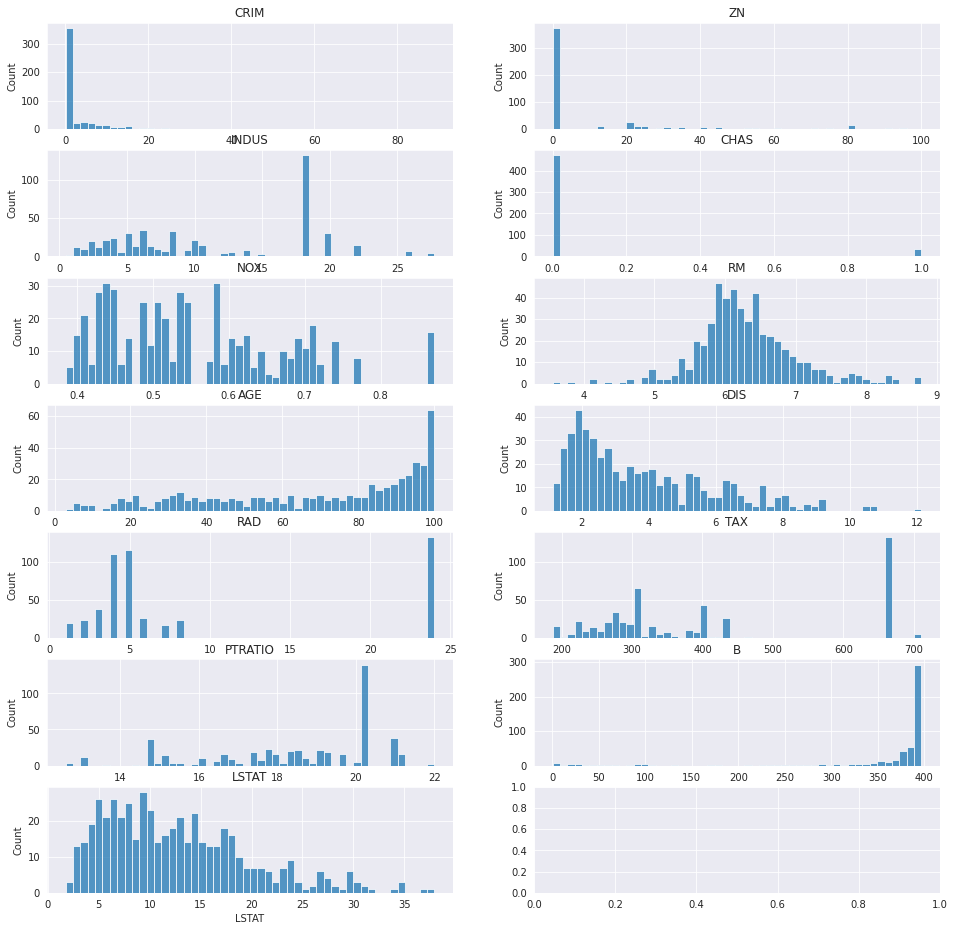

In [ ]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(16,16))
columns = boston_trimmed.columns

row, col = 0, 0

for i, column in enumerate(columns):
  g = sns.histplot(boston_trimmed[column], ax=ax[row][col], bins=50)
  g.set_title(column)
  col += 1
  if col == 2:
    col = 0
    row += 1


We see that a number of features are heavily skewed, e.g. ZN. 

Looking at each plot, we see no anomalies we need to be worried about. 

Further ideas for analysis:

We notice that the 'ZN' values have a positive correlation once we go past the 0 values. This makes sense - the more land, the higher the house price. W

We also notice a large gap in the 'TAX' data. This indicates some sort of tax bracket. We would expect house price to be correlated with this. 

## Correlations

We first look at the correlation of each feature to the price. 

In [ ]:
correlations = boston.corr()['CMEDV'].sort_values()
correlations

LSTAT     -0.740836
PTRATIO   -0.505655
INDUS     -0.484754
TAX       -0.471979
NOX       -0.429300
CRIM      -0.389582
RAD       -0.384766
AGE       -0.377999
LON       -0.322947
TOWNNO    -0.265134
LAT        0.006826
CHAS       0.175663
DIS        0.249315
B          0.334861
ZN         0.360386
TRACT      0.428252
RM         0.696304
MEDV       0.998476
CMEDV      1.000000
Name: CMEDV, dtype: float64

The most promising features seem to be LSTAT and RM. Let's look at them in a detail. 

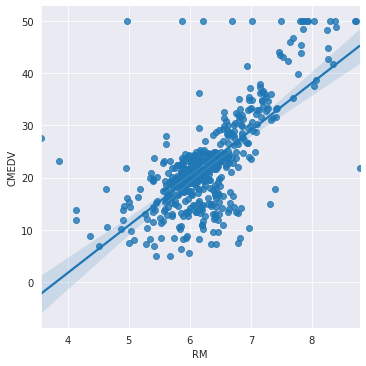

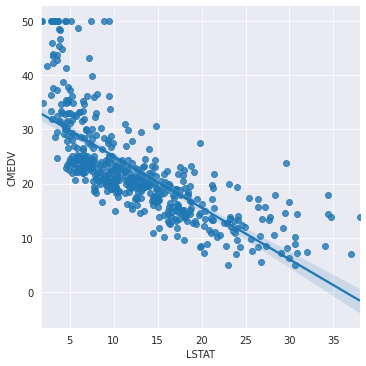

In [ ]:
sns.lmplot(data=boston, x='RM', y='CMEDV')
sns.lmplot(data=boston, x='LSTAT', y='CMEDV')

We see clear correlations with these features. 

## Collinearity

Considering the number of features, we should be worried about features being correlated with each other. Here is a correlation heatmap and pairplot

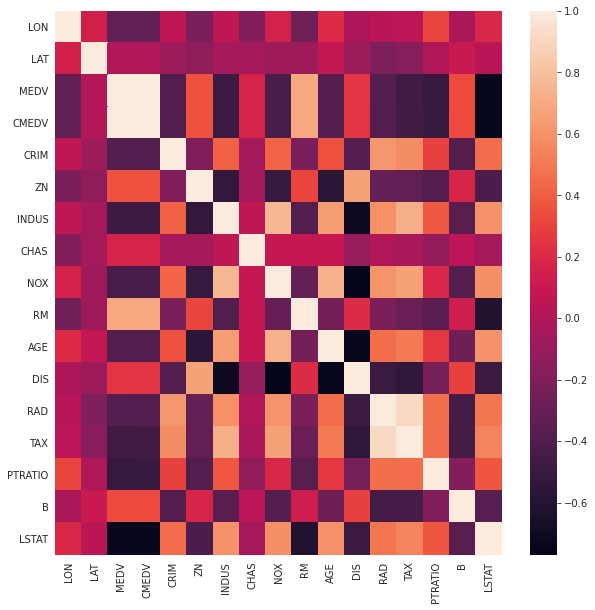

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(boston.drop(columns=['TOWN', 'TOWNNO', 'TRACT']).corr())

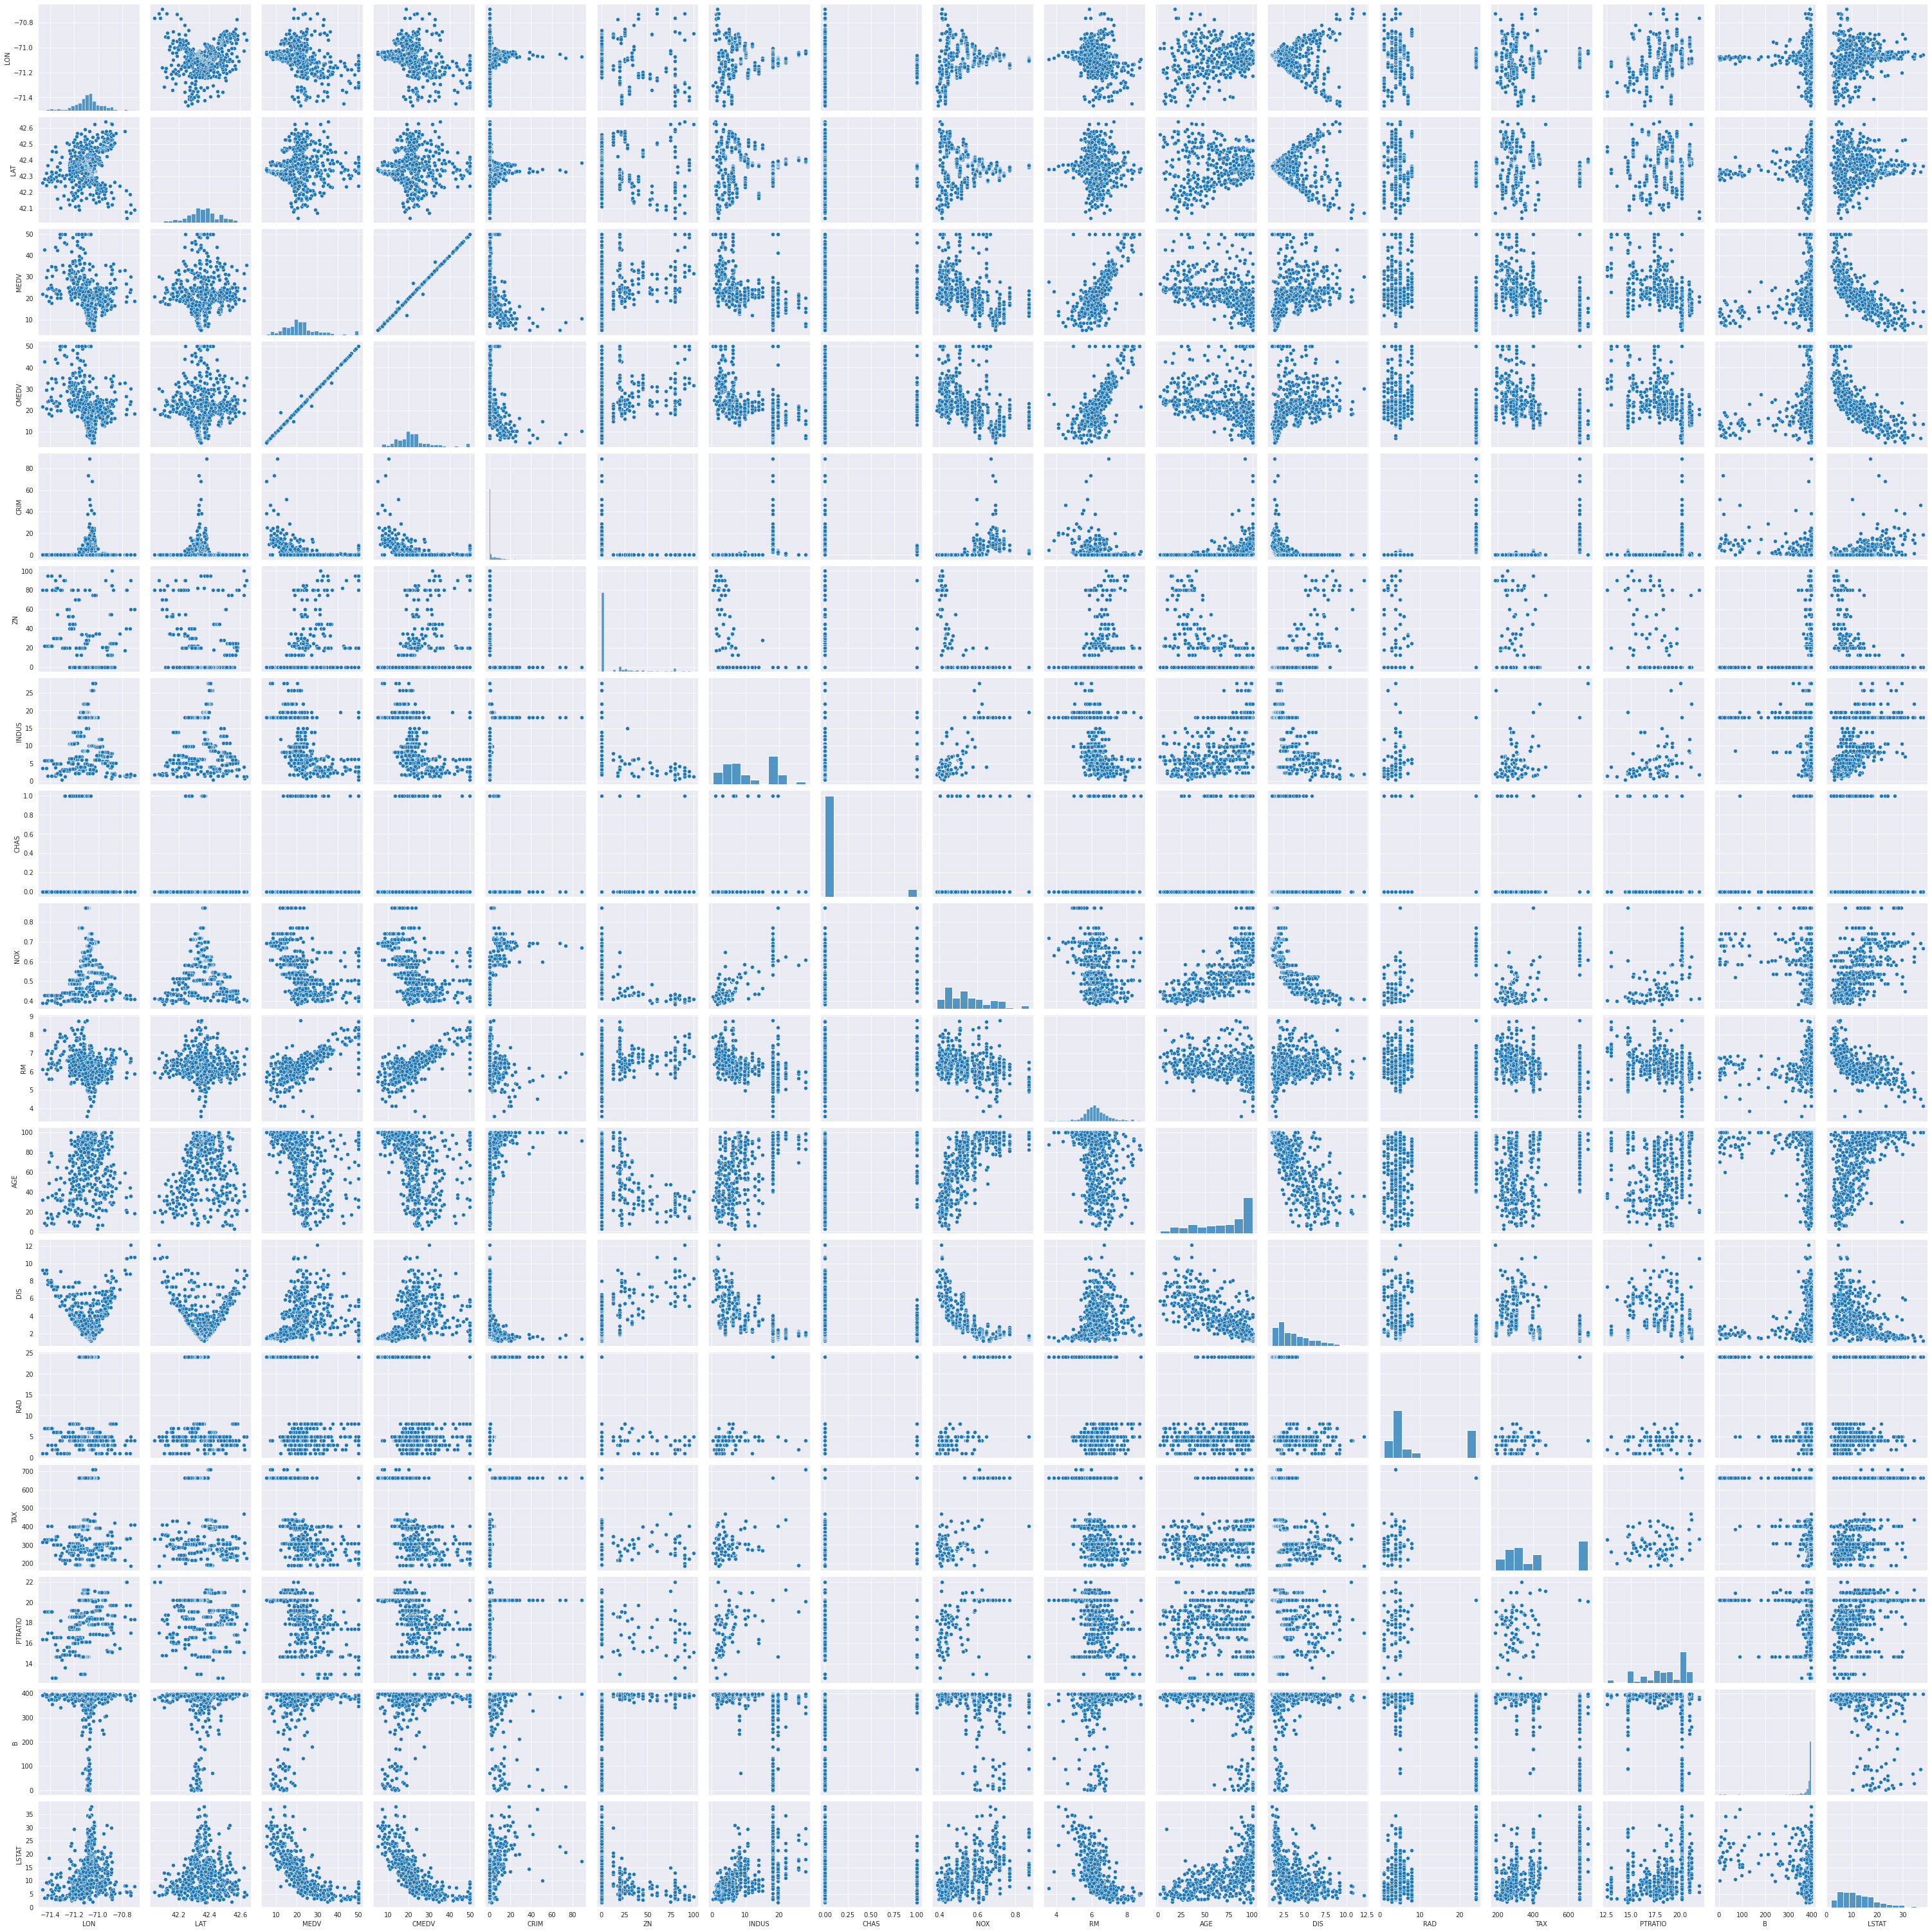

In [ ]:
sns.pairplot(data=boston.drop(columns=['TOWN', 'TOWNNO', 'TRACT']))

We see a few features that a strong relationship. With this in mind, it is probably worth using polynomial features in our model. 

So far, we have talked about how two features might be correlated with each other. Three or more features may be correlated with each other (multicollinearity). If we had more time, we could have analysed this further - perhaps using Variable Inflation Factors (VIF).

# Location exploration

The dataset is ultimately focussed on a city. With this in mind, we thought it would be useful to map the data directly onto Boston to get a sense of the area. We were able to see how different features were spread out over the city. We used Folium to do this.

In [ ]:
!pip install folium

In [ ]:
!pip install branca

In [ ]:
import folium
import branca
import branca.colormap as cm

In [ ]:
m = folium.Map(location=[42.3, -71.05], zoom_start=10, width=500, height=500)

column = 'TRACT' # Change this for different heatmaps
title_html = '''
             <h3  style="font-size:16px"><b>{}</b></h3>
             '''.format(column)

def color_value(min, max, p):
  colormap = cm.LinearColormap(colors=['black', 'purple', 'red', 'pink'], vmin=min, vmax=max)
  return colormap(p)
  #return "black"

for idx, row in boston.iterrows():
  folium.Circle([row['LAT'], row['LON']], radius=100, color=color_value(boston["{}".format(column)].min(), boston["{}".format(column)].max(), row[column])).add_to(m)
m.get_root().html.add_child(folium.Element(title_html))
m

From these visualisations, we gained some interesting insights about the features - for more detail see the report.

# Feature engineering

Given the correlations between features, we decided to implement some further features. 

In [ ]:
# We used sklearn to transform the features and form combinations. 
poly_feat = boston.drop(columns=['MEDV', 'TOWN', 'TOWNNO', 'TRACT', 'LON', 'LAT']).copy()

poly_target = boston['CMEDV']
poly_feat = poly_feat.drop(columns=['CMEDV'])

from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures()
poly_transformer.fit(poly_feat)

poly_feat = poly_transformer.transform(poly_feat)

print('Polynomial Features Shape: ', poly_feat.shape)

Polynomial Features Shape:  (506, 105)


This is a big increase in features (35->105). Thus, we should ensure the model doesn't overfit when we evaluate.

In [ ]:
poly_feat = pd.DataFrame(poly_feat, columns = poly_transformer.get_feature_names(boston.drop(columns=['MEDV', 'TOWN', 'TOWNNO', 'TRACT', 'LON', 'LAT']).columns[1:]))

poly_feat['CMEDV'] = poly_target

print(poly_feat.corr()['CMEDV'].sort_values().head(7))
print(poly_feat.corr()['CMEDV'].sort_values().tail(7))

PTRATIO LSTAT   -0.753002
LSTAT           -0.740836
RM LSTAT        -0.732928
NOX LSTAT       -0.703901
TAX LSTAT       -0.678641
AGE LSTAT       -0.674210
INDUS LSTAT     -0.654813
Name: CMEDV, dtype: float64
ZN NOX    0.379262
ZN RM     0.392644
RM B      0.582728
RM        0.696304
RM^2      0.719186
CMEDV     1.000000
1              NaN
Name: CMEDV, dtype: float64


Considering the size of the dataset (506), 105 features is likely too many. We decided to trim the polynomial features to only those with a correlation of >0.65 with the price. This left us with 8 new features. 





With more time, we could have added in some more nuanced features. For example, we noticed in the dataset earlier that there were some distinct tax brackets - this could be interesting to explore.

In [ ]:
poly_feat_trimmed = [feature for feature in poly_feat.corr()['CMEDV'] if abs(feature) > 0.65]

# Alternative datasets

We have a number of ideas for further datasets. Unfortunately we didn't have time to analyse them all but here were our ideas:

*   Location of schools in Boston: How does does distance from schools affect house price?

*   Location of tract from centre of Boston. How does distance from centre affect house price?

*   Density of houses. How does distance from other houses affect house price?



# Model Fitting

We now begin fitting the data to various regression models. We used Linear Regression, Random Forest, Nearest Neighbours and finally Gradient Boosted Regression. 

We first try linear regression. Due to the small dataset, this works better with a smaller test dataset.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = boston.drop(['CMEDV', 'TOWN'],axis = 1), boston['CMEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)
print(f"There are {X.shape} observations in the data")
print(f"There are {X_train.shape} observations in the train, {X_test.shape} observations in test")
lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate the Mean Squared Error on train and test set
print(f"Root Mean Squared Error - Train: {mean_squared_error(y_train, lr.predict(X_train), squared=False)}")
print(f"Root Mean Squared - Test: {mean_squared_error(y_test, lr.predict(X_test), squared=False)}")


There are (506, 18) observations in the data
There are (455, 18) observations in the train, (51, 18) observations in test
Root Mean Squared Error - Train: 0.5146704634696008
Root Mean Squared - Test: 0.13183045615550174


Next up, random forest. This gives a much nicer error - there are lots of features.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
print(f"Root Mean Squared Error - Train: {mean_squared_error(y_train, rf.predict(X_train), squared=False)}")
print(f"Root Mean Squared - Test: {mean_squared_error(y_test, rf.predict(X_test), squared=False)}")


Root Mean Squared Error - Train: 0.2392357841953418
Root Mean Squared - Test: 0.11748641974087479


Then, nearest neighbours. This error is unacceptable - we believe this happens as there significant disparity in the density of certain feature values.

In [ ]:
from sklearn import neighbors

nn_reg = neighbors.KNeighborsRegressor(n_neighbors = 3)
nn_reg.fit(X, y)
print(f"Root Mean Squared Error - Train: {mean_squared_error(y_train, nn_reg.predict(X_train), squared=False)}")
print(f"Root Mean Squared - Test: {mean_squared_error(y_test, nn_reg.predict(X_test), squared=False)}")

Root Mean Squared Error - Train: 2.9703997584962742
Root Mean Squared - Test: 3.08848448003908


Last but not least, gradient boosted regression. Unfortunately, this doesn't do too much better.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print(f"Root Mean Squared Error - Train: {mean_squared_error(y_train, gbr.predict(X_train), squared=False)}")
print(f"Root Mean Squared - Test: {mean_squared_error(y_test, gbr.predict(X_test), squared=False)}")

Root Mean Squared Error - Train: 0.16442038247504429
Root Mean Squared - Test: 0.22251332339022148


Since linear regression and random forest are the best models, we perform cross validation to optimize the fitting.

In [ ]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lr, X, y, 
                             scoring = 'neg_mean_squared_error', cv=10)
def display_scores(scores):
    print('scores:', scores)
    print('mean:', scores.mean())
    print('std', scores.std())
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores: [0.7314078  0.20930003 0.18939897 0.54893996 0.72067592 0.22174253
 0.19581682 0.31959438 0.5367701  0.98479923]
mean: 0.46584457524502876
std 0.266990493617396


We also optimize the decision tree by parsing through 10 training sets. This doesn't end up helping much, probably again because of the small data set.

In [ ]:
scores = cross_val_score(rf,X, y, 
                         scoring = 'neg_mean_squared_error', cv=10 )
tree_rmse_scores = np.sqrt(-scores)             
display_scores(tree_rmse_scores) 

scores: [0.92561648 0.19502489 0.15326742 0.72530845 0.81625716 0.32931313
 0.13495992 0.54740247 0.59100249 1.04699504]
mean: 0.5465147438010657
std 0.3155391028007314


Random forest seems to be the best. We could finetune the hyperparameters to check if we can optimise it further. We fine tune the combinations uwith the result that the 'max feature number' is 18 and 'number of estimators' is 30.  

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 16 (4×4) combinations of hyperparameters
    {'n_estimators': [20, 25, 30,35], 'max_features': [14,16,18,19]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X, y)
grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this t

{'max_features': 18, 'n_estimators': 30}

We now have our final model.

In [ ]:
final_model = grid_search.best_estimator_
print(f"Root Mean Squared Error - Train: {mean_squared_error(y_train, final_model.predict(X_train), squared=False)}")
print(f"Root Mean Squared - Test: {mean_squared_error(y_test, final_model.predict(X_test), squared=False)}")

Root Mean Squared Error - Train: 0.2365239728729198
Root Mean Squared - Test: 0.060556604895866076


# Conclusion

We set out to predict house prices from a number of features. We've found that the most effective model is the random forest regression

We found out a number of other insights in the data - see our report for more details!